<a href="https://colab.research.google.com/github/khus-hi/Brain-tumor-detection/blob/main/Brain_tumor_20_patch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix,confusion_matrix
import seaborn as sns
from sklearn.model_selection   import train_test_split

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense,Add, Dropout, Resizing,Rescaling,InputLayer,Flatten,LayerNormalization, MultiHeadAttention

from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers,Model
from tensorflow.keras.regularizers import L2
from tensorflow.keras.metrics import CategoricalAccuracy, TopKCategoricalAccuracy

from tensorflow.keras.preprocessing.image import load_img
#from tensorflow.keras.utils import plot_model
from functools import partial

In [ ]:
import pandas as pd
#import plotly.express as px
from tensorflow.keras.layers import RandomRotation, RandomFlip, RandomContrast
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
learning_rate = 0.0001
class_name=['glioma','meningioma','notumor','pituitary']
#class_name = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
weight_decay = 0.0001
num_classes=4
batch_size =32
num_epochs = 120
image_size = 225  # We'll resize input images to this size
patch_size = 20  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
Num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
num_layers = 15
Hidden_size=64
mlp_head_units = 1024

importing from drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

# Step 1: Extract the ZIP file to a specific folder
with zipfile.ZipFile('/content/drive/MyDrive/archive (5).zip', 'r') as zip_ref:
    zip_ref.extractall('/content/temp')

# Step 2: List the files in the extracted folder
os.listdir('/content/temp')

# Step 3: Refresh the File Explorer manually or list files again


['Training', 'Testing']

In [ ]:
!ls /content/
!ls /content/temp

drive  sample_data  temp
Testing  Training


In [ ]:
train_data = r'/content/temp/Training'
test_data = r'/content/temp/Testing'

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_data,
    labels='inferred',
    label_mode='categorical',
    class_names=class_name,
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=(image_size,image_size),
    shuffle=True,
    seed=99,
    validation_split=0.2,
    subset='training',
)
val_dataset = tf.keras.utils.image_dataset_from_directory(
    train_data,
    labels='inferred',
    label_mode='categorical',
    class_names=class_name,
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=(image_size,image_size),
    shuffle=True,
    seed=99,
    validation_split=0.2,  # Use 20% of the data for validation
    subset='validation',
)
test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_data,
    labels='inferred',
    label_mode='categorical',
    class_names=class_name,
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=(image_size,image_size),
    shuffle=True,
    seed=99,
)

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
Found 1311 files belonging to 4 classes.


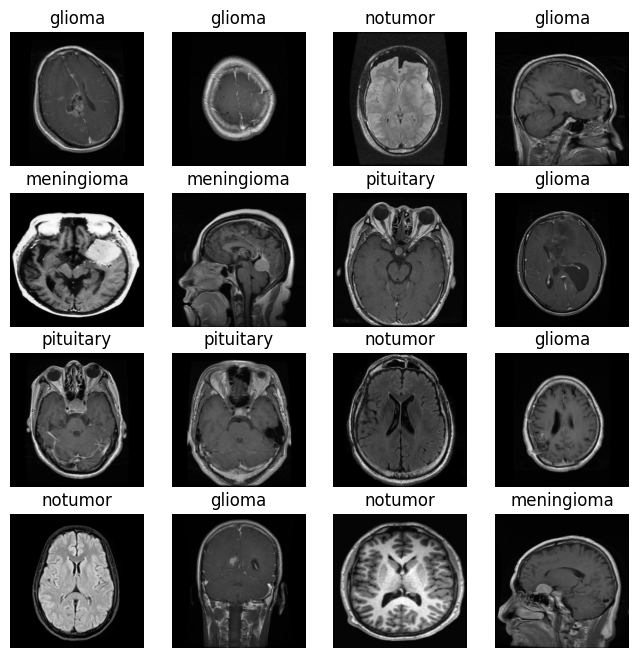

In [ ]:
plt.figure(figsize=(8, 8))
for images, labels in train_dataset.take(10):
    for i in range(min(16, len(images))):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i] / 255., cmap='gray')
        plt.title(class_name[tf.argmax(labels[i]).numpy()])
        plt.axis("off")

plt.show()

In [ ]:
augment_layers = tf.keras.Sequential([
    RandomRotation(factor=(-0.25, 0.2501)),
   RandomFlip("horizontal_and_vertical",seed=42),  # Specify a seed for reproducibility
])

In [ ]:
# Define a custom preprocessing function
def process_data(image, label):
    augmented_image=augment_layers(image)
    resized_image = tf.image.resize(augmented_image, size=(image_size, image_size))
    return resized_image, label

# Apply augmentation and preprocessing to the dataset
training_dataset = (
    train_dataset.
    shuffle(1000)
    .map(partial(process_data),num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
vali_dataset=(
   val_dataset.shuffle(1000)
    .prefetch(tf.data.AUTOTUNE)


)

In [ ]:
input_tensor = next(iter(training_dataset))[0]

In [ ]:
patche=tf.image.extract_patches(images=input_tensor,
                               sizes=[1,patch_size,patch_size,1],
                                strides=[1,patch_size,patch_size,1],
                                rates=[1,1,1,1],
                                 padding='VALID')

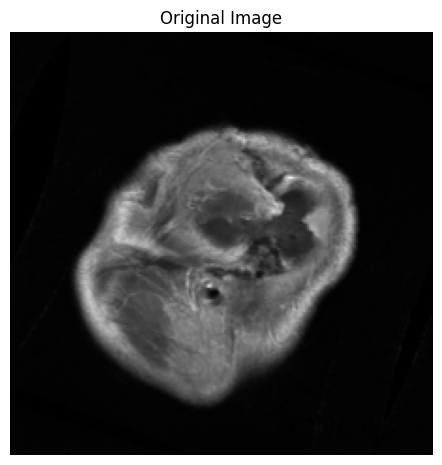

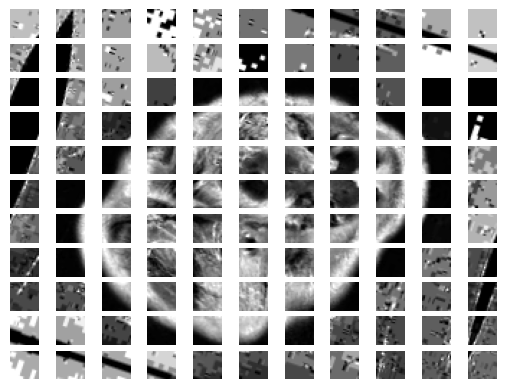

In [ ]:
plt.figure(figsize=(12, 12))

batch_size, patch_rows, patch_cols, channels = patche.shape
plt.subplot(1, 2, 1)
plt.imshow(input_tensor[0],cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.show()
for i in range(patch_rows):
    for j in range(patch_cols):
        ax = plt.subplot(patch_rows, patch_cols, i * patch_cols + j + 1)
        plt.imshow(patche[0, i, j, :].numpy().reshape (patch_size,patch_size, 1),cmap='gray')
        plt.axis("off")

plt.show()

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, patch_size,Hidden_size):
        super(PatchEncoder, self).__init__(name='patch_encoder')
        self.linear_projection=Dense(Hidden_size)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=Hidden_size
        )

        self.num_patches=num_patches

    def call(self, image):
        batch_size = tf.shape(image)[0]  # Retrieve batch size
        patches=tf.image.extract_patches(images=image,
                                sizes=[1,patch_size,patch_size,1],
                                strides=[1,patch_size,patch_size,1],
                                rates=[1,1,1,1],
                                 padding='VALID'
                                )

        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patches.shape[-1]])
        embedding_input=tf.range(start=0,limit =self.num_patches,delta=1)
        output=self.linear_projection(patches)+ self.position_embedding(embedding_input)
        return output

In [ ]:
class TransformerEncoder(layers.Layer):
    def __init__(self, Num_heads,Hidden_size):
        super(TransformerEncoder, self).__init__(name='transformer_encoder')
        self.layer_norm_1=LayerNormalization()
        self.layer_norm_2=LayerNormalization()

        self.multi_head_att=MultiHeadAttention(Num_heads,Hidden_size)

        self.dense_1=Dense(Hidden_size,activation=tf.nn.gelu)
        self.dense_2=Dense(Hidden_size,activation=tf.nn.gelu)


    def call(self, input):
        x=self.layer_norm_1(input)
        x1=self.multi_head_att(x,x)

        x1=Add()([x1,input])
        x2=self.layer_norm_2(x1)
        x2=self.dense_1(x2)
        output=self.dense_1(x2)
        output=Add()([output,x1])

        return output

In [ ]:
class VIT(tf.keras.Model):
    def __init__(self, Num_heads, Hidden_size, num_patches, num_layers, mlp_head_units):
        super(VIT, self).__init__(name='vision_transformer')
        self.num_layers = num_layers
        self.patch_encoder = PatchEncoder(patch_size, Hidden_size)
        self.trans_encoder = [TransformerEncoder(Num_heads, Hidden_size) for _ in range(num_layers)]
        self.flatten = layers.Flatten()
        self.dense_1 = layers.Dense(mlp_head_units, activation='relu')
        self.dense_2 = layers.Dense(mlp_head_units, activation='relu')
        self.dense_3 = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        x = self.patch_encoder(inputs)  # Get encoded patches
        for i in range(self.num_layers):
            x = self.trans_encoder[i](x)  # Apply transformer encoder layers

        x = self.flatten(x)
        x = self.dense_1(x)
        x = self.dense_2(x)
        output = self.dense_3(x)
        return output

# Create and compile the VIT model
vit = VIT(Num_heads, Hidden_size, num_patches, num_layers, mlp_head_units)

In [ ]:
loss_funcion=tf.keras.losses.CategoricalCrossentropy(
    from_logits=False,

)

In [ ]:

metrics=[CategoricalAccuracy(name= 'accuracy'),TopKCategoricalAccuracy(k=2,name='top_k_accuracy')]

In [ ]:
vit.compile(
    optimizer=Adam(learning_rate=learning_rate),
                   loss=loss_funcion,
                   metrics=metrics

)

In [ ]:
# Define the filepath to save the model weights
checkpoint_filepath = "/kaggle/working/checkpoint.weights.h5"

# Define the ModelCheckpoint callback
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_filepath,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True
)

In [ ]:
# Train the model
history = vit.fit(
    training_dataset,
    epochs=num_epochs,
    verbose=1,
    validation_data=vali_dataset,
    callbacks=[checkpoint_callback]

)

Epoch 1/120


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'transformer_encoder', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


143/143 ━━━━━━━━━━━━━━━━━━━━ 121s 358ms/step - accuracy: 0.3870 - loss: 44.9409 - top_k_accuracy: 0.7021 - val_accuracy: 0.5123 - val_loss: 6.7191 - val_top_k_accuracy: 0.7793
Epoch 2/120
143/143 ━━━━━━━━━━━━━━━━━━━━ 20s 100ms/step - accuracy: 0.4960 - loss: 7.0668 - top_k_accuracy: 0.7633 - val_accuracy: 0.5876 - val_loss: 4.0755 - val_top_k_accuracy: 0.8363
Epoch 3/120
143/143 ━━━━━━━━━━━━━━━━━━━━ 20s 109ms/step - accuracy: 0.5629 - loss: 4.1407 - top_k_accuracy: 0.8105 - val_accuracy: 0.6243 - val_loss: 2.8151 - val_top_k_accuracy: 0.8687
Epoch 4/120
143/143 ━━━━━━━━━━━━━━━━━━━━ 18s 93ms/step - accuracy: 0.5953 - loss: 3.0399 - top_k_accuracy: 0.8417 - val_accuracy: 0.5709 - val_loss: 2.6447 - val_top_k_accuracy: 0.8415
Epoch 5/120
143/143 ━━━━━━━━━━━━━━━━━━━━ 22s 109ms/step - accuracy: 0.6003 - loss: 2.5115 - top_k_accuracy: 0.8318 - val_accuracy: 0.6436 - val_loss: 1.9027 - val_top_k_accuracy: 0.8634
Epoch 6/120
143/143 ━━━━━━━━━━━━━━━━━━━━ 19s 97ms/step - accuracy: 0.6224 - loss:

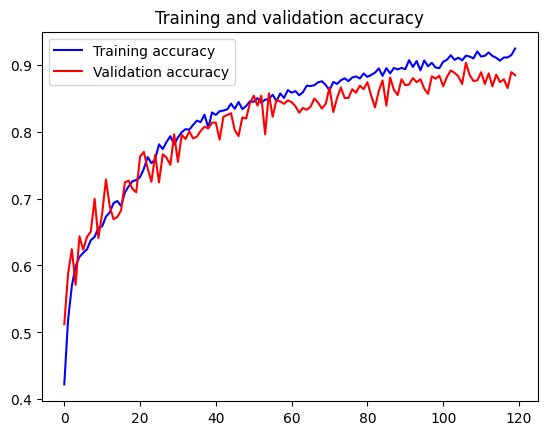

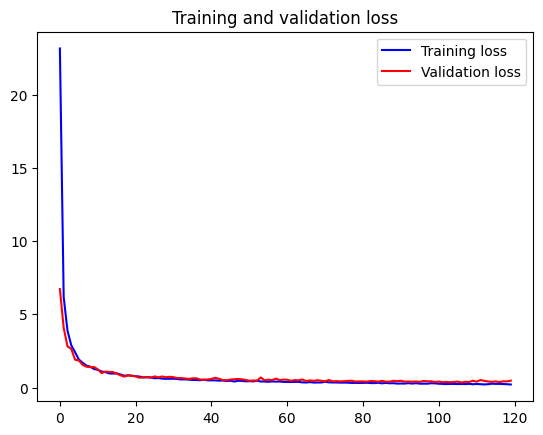

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
# Save the model in the Keras format
vit.save('/kaggle/working/model.keras')

In [ ]:
vit.save_weights('/kaggle/working/model.weights.h5')

In [ ]:
pred = vit.predict(test_dataset)

41/41 ━━━━━━━━━━━━━━━━━━━━ 15s 223ms/step


In [ ]:
vit.evaluate(test_dataset)

41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 151ms/step - accuracy: 0.8570 - loss: 0.4675 - top_k_accuracy: 0.9807


[0.536363422870636, 0.859649121761322, 0.9877955913543701]

In [ ]:
predicted=[]
labels=[]
for im, label in test_dataset:
    predicted.append(vit(im))
    labels.append(label.numpy())

In [ ]:
pred= np.concatenate([np.argmax(predicted[:-1],axis=-1).flatten(),np.argmax(predicted[-1],axis=-1).flatten()])
lab= np.concatenate([np.argmax(labels[:-1],axis=-1).flatten(),np.argmax(labels[-1],axis=-1).flatten()])

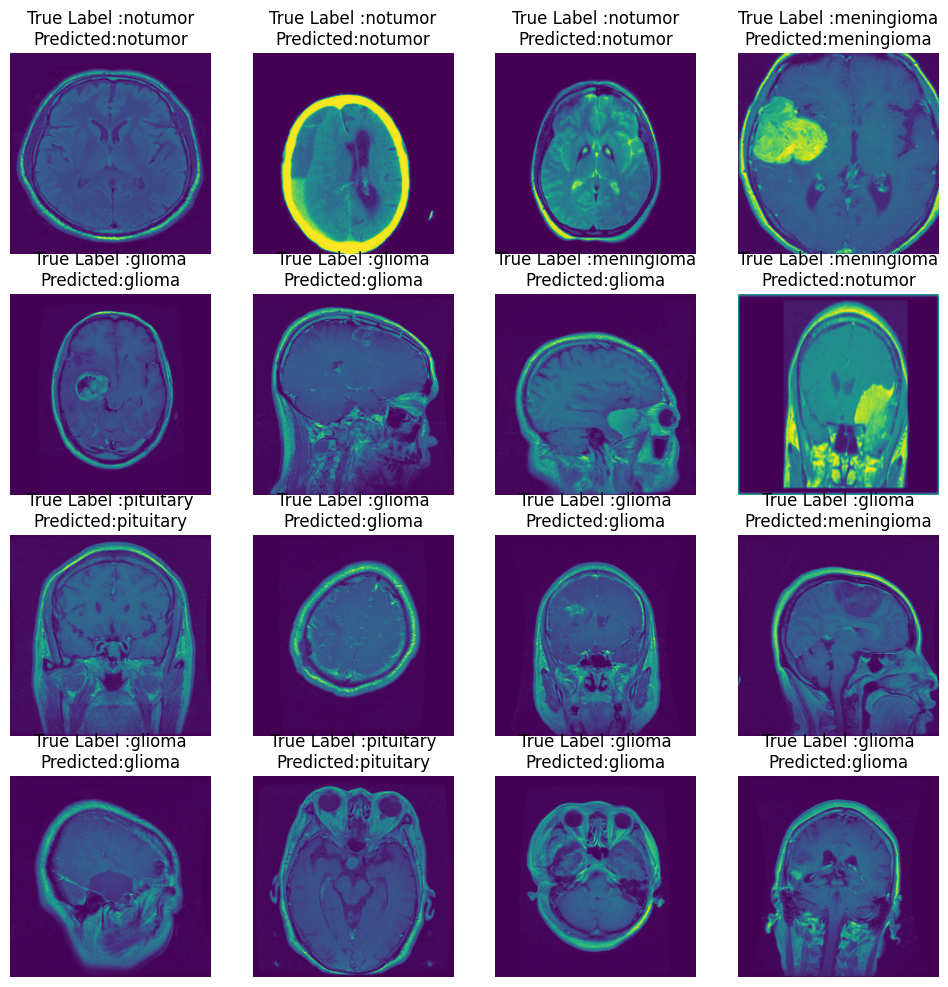

In [ ]:
plt.figure(figsize=(12,12))
for   images,labels in  test_dataset.take(10):
  for i   in range(16):
   ax=plt.subplot(4,4,i+1)

   plt.imshow(images[i]/255.)
   plt.title("True Label :"+ class_name[tf.argmax(labels[i],axis=0).numpy()] + "\n" + "Predicted:" + class_name[tf.argmax(vit(tf.expand_dims(images[i],axis=0)),axis= -1).numpy()[0]])
   plt.axis("off")

[[232  48   1  19]
 [ 41 203  40  22]
 [  0   3 401   1]
 [  1   8   0 291]]


Text(0.5, 58.7222222222222, 'Predicted')

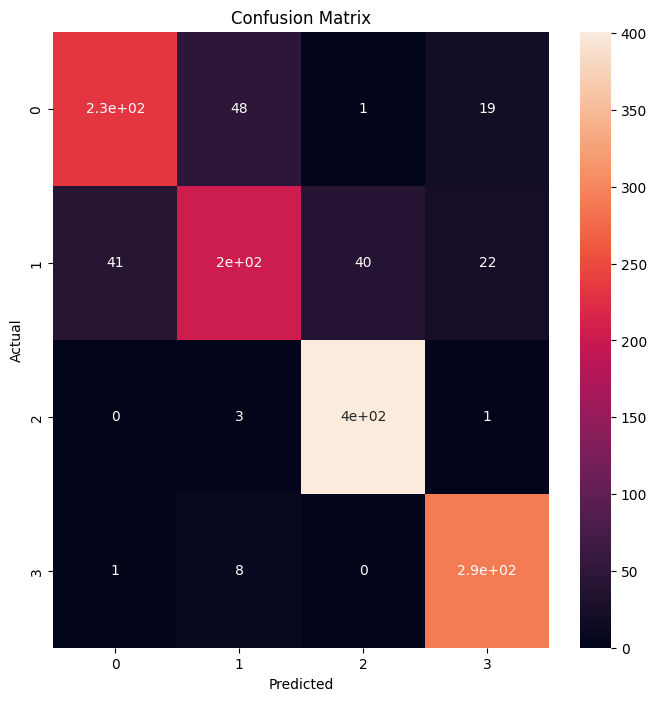

In [ ]:
cm=confusion_matrix(lab,pred)
print(cm)
plt.figure(figsize=(8,8))
sns.heatmap(cm,annot=True)
plt.title("Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel("Predicted")